### Mnist分类任务：

- 网络基本构建与训练方法，常用函数解析

- torch.nn.functional模块

- nn.Module模块


### 读取Mnist数据集
- 会自动进行下载

In [2]:
%matplotlib inline

In [ ]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [5]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

784是mnist数据集每个样本的像素点个数

(50000, 784)
5


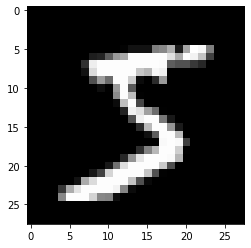

In [11]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)
print(y_train[0])

注意数据需转换成tensor才能参与后续建模训练


In [12]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


### torch.nn.functional 很多层和函数在这里都会见到

torch.nn.functional中有很多功能，后续会常用的。那什么时候使用nn.Module，什么时候使用nn.functional呢？一般情况下，如果模型有可学习的参数，最好用nn.Module，其他情况nn.functional相对更简单一些

In [13]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb.mm(weights) + bias

In [18]:
bs = 64
xb = x_train[0:bs]  # a mini-batch from x
yb = y_train[0:bs]
weights = torch.randn([784, 10], dtype = torch.float,  requires_grad = True) 
bs = 64
bias = torch.zeros(10, requires_grad=True)

print(loss_func(model(xb), yb))

tensor(12.2657, grad_fn=<NllLossBackward0>)


### 创建一个model来更简化代码

- 必须继承nn.Module且在其构造函数中需调用nn.Module的构造函数
- 无需写反向传播函数，nn.Module能够利用autograd自动实现反向传播
- Module中的可学习参数可以通过named_parameters()或者parameters()返回迭代器

In [14]:
from torch import nn

class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 256)
        self.out  = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x
        

In [15]:
net = Mnist_NN()
print(net)


Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


可以打印我们定义好名字里的权重和偏置项

In [16]:
for name, parameter in net.named_parameters():
    print(name, parameter,parameter.size())

hidden1.weight Parameter containing:
tensor([[ 0.0324,  0.0030,  0.0184,  ...,  0.0215,  0.0257, -0.0061],
        [ 0.0096,  0.0326, -0.0067,  ..., -0.0135,  0.0112,  0.0225],
        [-0.0289, -0.0136,  0.0181,  ..., -0.0064,  0.0344,  0.0057],
        ...,
        [-0.0344, -0.0198, -0.0321,  ..., -0.0020,  0.0025,  0.0259],
        [ 0.0335, -0.0023, -0.0256,  ...,  0.0072,  0.0025,  0.0322],
        [ 0.0262,  0.0292,  0.0305,  ..., -0.0090, -0.0210,  0.0316]],
       requires_grad=True) torch.Size([128, 784])
hidden1.bias Parameter containing:
tensor([ 0.0002, -0.0181, -0.0115,  0.0013,  0.0100, -0.0241, -0.0066, -0.0123,
        -0.0010, -0.0162,  0.0311, -0.0234, -0.0101, -0.0140,  0.0179,  0.0032,
         0.0355, -0.0030,  0.0355,  0.0255, -0.0077, -0.0038, -0.0174, -0.0024,
         0.0138,  0.0279, -0.0137,  0.0092,  0.0038,  0.0003, -0.0007,  0.0093,
         0.0219, -0.0231,  0.0161, -0.0108,  0.0165, -0.0220,  0.0050, -0.0194,
        -0.0134, -0.0216, -0.0008,  0.0349, 

### 使用TensorDataset和DataLoader来简化

In [19]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [20]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

- 一般在训练模型时加上model.train()，这样会正常使用Batch Normalization和 Dropout
- 测试的时候一般选择model.eval()，这样就不会使用Batch Normalization和 Dropout

In [21]:
import numpy as np

def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    for step in range(steps):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print('当前step:'+str(step), '验证集损失：'+str(val_loss))

In [22]:
from torch import optim
def get_model():
    model = Mnist_NN()
    return model, optim.SGD(model.parameters(), lr=0.001)

In [23]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

### 三行搞定！

In [24]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(25, model, loss_func, opt, train_dl, valid_dl)

当前step:0 验证集损失：2.281420397567749
当前step:1 验证集损失：2.251999032211304
当前step:2 验证集损失：2.205302934265137
当前step:3 验证集损失：2.1274710468292235
当前step:4 验证集损失：2.000798610305786
当前step:5 验证集损失：1.8080479150772095
当前step:6 验证集损失：1.552802353477478
当前step:7 验证集损失：1.289136668586731
当前step:8 验证集损失：1.0758441564559937
当前step:9 验证集损失：0.9204948238372803
当前step:10 验证集损失：0.808637120437622
当前step:11 验证集损失：0.7245394794464112
当前step:12 验证集损失：0.6597387674331665
当前step:13 验证集损失：0.6087180676460267
当前step:14 验证集损失：0.5672475024223328
当前step:15 验证集损失：0.5329348666667938
当前step:16 验证集损失：0.5044695672512054
当前step:17 验证集损失：0.4808740779399872
当前step:18 验证集损失：0.46069016160964965
当前step:19 验证集损失：0.4435046859264374
当前step:20 验证集损失：0.4282842843055725
当前step:21 验证集损失：0.41539084753990174
当前step:22 验证集损失：0.40365223698616026
当前step:23 验证集损失：0.3936210869073868
当前step:24 验证集损失：0.3844073879241943
